<img src="kschool.png" width="120" height="120" align="right"/>

# collaborative-filtering (CF)

https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html

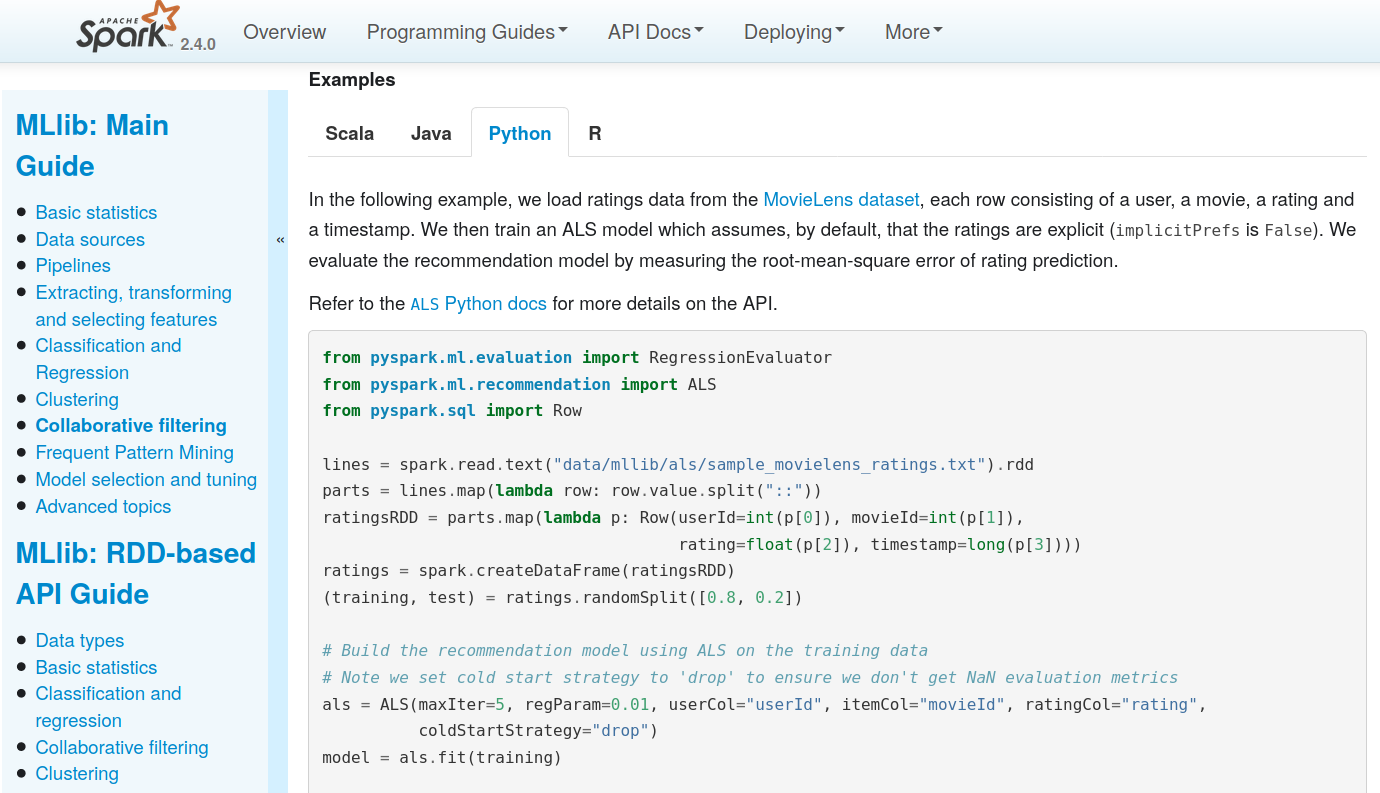

### Instalación de pyspark en Jupyter

<div class  = "alert alert-info">

En caso de no tener pyspark en el ordenador. Habría que instalarlo mediante el comando **"pip install pyspark"**, tal y cómo se recomienda en la web: https://spark.apache.org/downloads.html
    
</div>

In [1]:
'''Comando de instalación por consola de pyspark'''

# !pip install pyspark

'Comando de instalación por consola de pyspark'

<div class  = "alert alert-success">

**Warning**: Si, tras ello, no funcionase, los motivos principales suelen ser:

- No está la versión de Java adecuada, que es la 1.8
- No está la versión de Python adecuada, que es la 3.x
- No están creadas las variables de entorno PYSPARK_PYTHON y PYSPARK_DRIVER_PYTHON
    
</div>

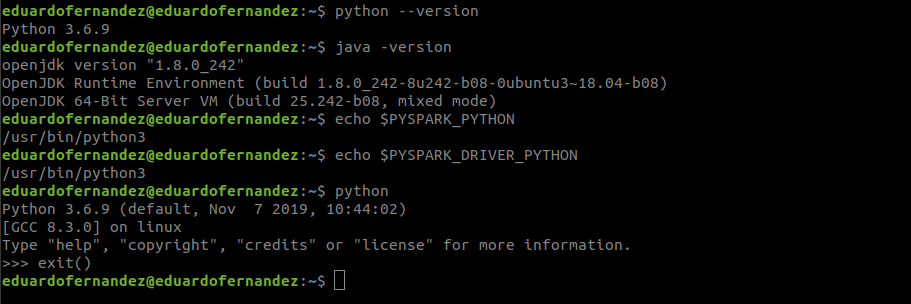

Spark está escrito en Scala, que es un lenugja de programación fuertemente tipado.

Scala es un lenguage POO. Como no es el más óptimo para análisis de datos se hizo pyspark, que traduce python a Scala.

Spark es un lenguaje creado para Big Data, es un lenguaje para plataformas ditribuidas. Imaginemos que tenemos 100M de registros, lo cual es inviable analizar en nuestro ordenador. Spark coge esa matriz, que coge esa matriz de 100M de registros, los parte en cachitos, lo distribuye entre ordenadores y te lo devuelve, lo cual hace que los procesos sean más ágiles.

Se usa mucho por todo ello para IOT (Internet de las cosas), con información en tiempo real.

### Dataset

In [7]:
'''Leemos los ficheros donde están las peliculas y las votaciones de los usuarios'''

import pandas as pd

folder = 'data/movies'

pd_ratings = pd.read_csv(folder+'/ratings.csv')
pd_movies = pd.read_csv(folder+'/movies.csv')

In [8]:
pd_ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

### Traducimos todo spark dataframe

In [10]:
'''Es necesario crear una sesión de Spark (2.2.4)'''

from pyspark.sql import SparkSession

#Creamos la sesión de Spark
spark = SparkSession.builder.getOrCreate()

In [11]:
'''Librerías básicas de Spark'''

import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

In [13]:
'''El análogo a Pandas dataframe es Spark dataframe, al cual es necesario darle un schema de construcción'''

schema = StructType([StructField("userId", IntegerType(), True),
                     StructField("movieId", IntegerType(), True),
                     StructField("rating", DoubleType(), True),
                     StructField("timestamp", IntegerType(), True)])

#Creamos el DataFrame de Spark
df_ratings = spark.createDataFrame(pd_ratings, schema=schema)
#En lugar de head se usa show
df_ratings.show(5)


schema = StructType([StructField("movieId", IntegerType(), True),
                     StructField("title", StringType(), True),
                     StructField("genres", StringType(), True)])

df_movies = spark.createDataFrame(pd_movies, schema=schema)
#En lugar de head se usa show
df_movies.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Como se puede ver, visualizar dataframes en Spark es bastante rudimentario

### Construimos y entrenamos un modelo ALS

In [14]:
'''Configuración del modelo ALS en Spark'''

from pyspark.ml.recommendation import ALS

rec = ALS(maxIter=10, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating', nonnegative=True, coldStartStrategy="drop")

'''
Parámetros:

* rank:        Number of latent factors in the model (defaults to 10).
* maxIter:     Maximum number of iterations to run (defaults to 10).
* regParam:    Regularization parameter in ALS (defaults to 1.0). Es ka tasa de aprendizaje.
* nonnegative: Use nonnegative constraints for least squares (defaults to false).

'''

'\nParámetros:\n\n* rank:        Number of latent factors in the model (defaults to 10).\n* maxIter:     Maximum number of iterations to run (defaults to 10).\n* regParam:    Regularization parameter in ALS (defaults to 1.0).\n* nonnegative: Use nonnegative constraints for least squares (defaults to false).\n\n'

<div class  = "alert alert-success">

**Warning**: ALS only supports integers for user and item ids
    
</div>

### CF explícito vs. Implícito (knowledge-based recommender systems)

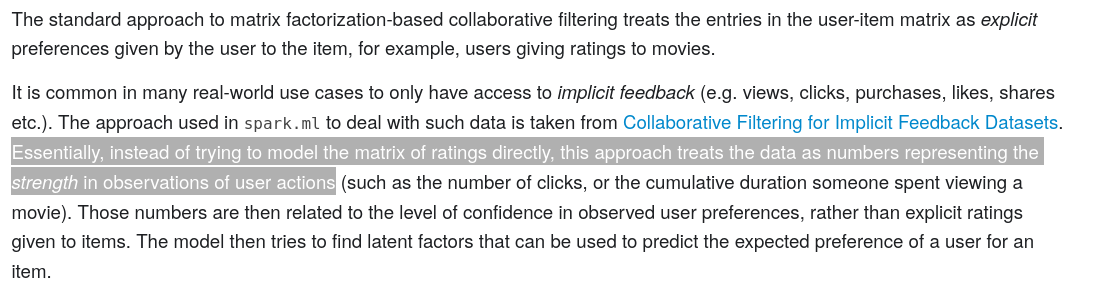

<div class  = "alert alert-info">

Algunos ejemplos de recolección de datos de forma explícitas son:

- Solicitar al usuario que pondere sobre la base de una escala proporcionada, algún tema en particular.
- Solicitar al usuario que pondere un conjunto de temas de una lista de temas favoritos.
- Presentar al usuario dos temas, y solicitarle que seleccione uno de ellos.
- Solicitar al usuario que cree una lista de temas de su preferencia.

Algunos ejemplos de recolección de datos de forma implícitas son:

- Guardar un registro de los temas que el usuario ha visto en una tienda en línea.
- Analizar el número de visitas que recibe un artículo
- Guardar un registro de los artículos que el usuario ha seleccionado.
- Obtener un listado de los artículos que el usuario ha seleccionado o visto en su computadora.
- Analizar las redes sociales de las que el usuario forma parte y de esta manera conocer sus gustos y preferencias.
    
</div>



### Cold-Start

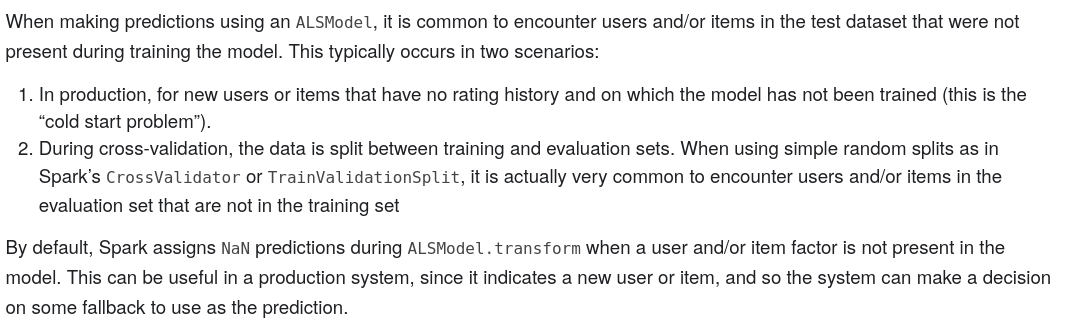

### Entrenamiento

In [15]:
rec_model = rec.fit(df_ratings)

### Transformación

In [17]:
df_predicted_ratings = rec_model.transform(df_ratings)
df_predicted_ratings.show(5)

+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|   191|    148|   5.0|829760897| 5.0661016|
|   133|    471|   4.0|843491793| 3.5185533|
|   597|    471|   2.0|941558175| 2.6407676|
|   385|    471|   4.0|850766697| 3.8873236|
|   436|    471|   3.0|833530187| 3.6751616|
+------+-------+------+---------+----------+
only showing top 5 rows



In [20]:
'''Escogemos un usuario y rankeamos las predicciones'''

user = 191

df_predicted_ratings.filter(F.col('userId') == user).orderBy(F.col('movieId')).show(5)  

df_predicted_ratings.filter(F.col('userId') == user).orderBy(F.col('prediction'), ascending=False).show(5)

+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|   191|      1|   4.0|829759809| 3.8606908|
|   191|      6|   4.0|829759809|  4.140134|
|   191|     16|   4.0|829759809|  4.464179|
|   191|     17|   5.0|829759809| 4.5250745|
|   191|     21|   4.0|829759809|  4.087516|
+------+-------+------+---------+----------+
only showing top 5 rows

+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|   191|    194|   5.0|829760898|  5.510898|
|   191|    213|   5.0|829760897|  5.247573|
|   191|     99|   5.0|829759809| 5.2128797|
|   191|    306|   5.0|829760898|  5.193349|
|   191|    308|   5.0|829760898|  5.165109|
+------+-------+------+---------+----------+
only showing top 5 rows



El error cuadrático medio es (prediction - rating)²/N

### Evaluación

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

rmse = evaluator.evaluate(df_predicted_ratings)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.5393809435069901


El error de 0.54 en una escala de 1-5 es muy aceptable.

In [24]:
'''Algo un poco más manual'''

# Con este comando creamos una nueva columna que es la diferencia y-y_hat
# Y lo pasamos a pandas para verlo en un histograma
pd_predicted_ratings = df_predicted_ratings.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.hist(pd_predicted_ratings.dif, bins=50)
plt.show()

<Figure size 640x480 with 1 Axes>

### Realizamos una predicción

In [29]:
'''Spark-ALS nos ofrece también comandos para la generación de recomendaciones'''

# Las 5 mejores peliculas para todos los usuarios
userRecs = rec_model.recommendForAllUsers(5)

# Filtramos para nuestro usuario concreto
userRecs.filter(F.col('userId')==user).show(1,False)

# Otros comandos para hacer predicciones
# rec_model.recommendForItemSubset
# rec_model.recommendForUserSubset

+------+--------------------------------------------------------------------------------------------+
|userId|recommendations                                                                             |
+------+--------------------------------------------------------------------------------------------+
|191   |[[25825, 9.433106], [7834, 8.62843], [25850, 8.564985], [7700, 8.126956], [3044, 7.7346725]]|
+------+--------------------------------------------------------------------------------------------+



In [30]:
'''Creamos una función ad-hoc para verlo en pandas'''

def recommendMovies(ratings, movies, model, user, nbRecommendations):
    dataSet = ratings.select('movieId').distinct().withColumn('userId', F.lit(user))
    moviesAlreadyRated = ratings.filter(ratings.userId == user).select('movieId', 'userId')
    
    predictions = model.transform(dataSet.subtract(moviesAlreadyRated))\
                       .dropna().orderBy('prediction', ascending=False)\
                       .limit(nbRecommendations).select('movieId', 'prediction')
    
    recommendations = predictions.join(movies, predictions.movieId == movies.movieId)\
                                 .select(predictions.movieId, movies.title, movies.genres, predictions.prediction)\
                                 .sort(F.col('prediction').desc())

    return recommendations

recommendMovies(df_ratings, df_movies, model, user, 5).toPandas()

NameError: name 'model' is not defined

### Train / Test split

In [15]:
'''Lo habitual es entrenar ALS mediante técnicas de machine learning y testear la predicción'''

(training, test) = df_ratings.randomSplit([0.8, 0.2])

Root-mean-square error = 1.0653055765668569


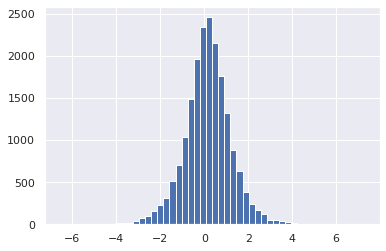

+------+-------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                  |
+------+-------------------------------------------------------------------------------------------------+
|191   |[[72167, 7.1626825], [3925, 6.704514], [1464, 6.3227706], [1587, 6.1260014], [119141, 6.0219345]]|
+------+-------------------------------------------------------------------------------------------------+



In [16]:
# Entrenamos con training set
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",  coldStartStrategy="drop")
model = als.fit(training)

# Testeamos con testing set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

pd_predictions = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

userRecs = model.recommendForAllUsers(5)
userRecs.filter(F.col('userId')==user).show(1,False)

El error RMSE o cuadrático medio es peor, así que habría que jugar con los parámetros de max_iter y reg_Param.

Como antes me daba 0.54 y ahora en el test me da 1, parece que tenía overfitted el modelo.

### El problema de la aleatoriedad

Como hay aleatoriedad en la asignación de partida de valores de las matrices, hay un problema de aleatoriedad, provocando que me dé a veces resultados diferentes.

Está transformación de matrices se produce porque , como no puede trabajar con matrices inmensas (pensar 100M x 100M) busca matrices reducidas,

In [19]:
'''Debido a la aleatoriedad dependiente en train/test split y en ALS, 
   los resultados varian entre repeticiones del mismo modelo'''

def repeatALS(data, k=3, userCol='userId', itemCol='movieId', ratingCol='rating', metricName='rmse'):
    evaluations = []
    for i in range(0, k):  
        (trainingSet, testingSet) = data.randomSplit([k - 1.0, 1.0])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        
        evaluator = RegressionEvaluator(metricName=metricName, labelCol='rating', predictionCol='prediction')
        evaluation = evaluator.evaluate(predictions.na.drop())
        evaluations.append(evaluation)
        
        print('Loop {}: {} = {}'.format(i + 1, metricName, evaluation))        
    return sum(evaluations) / float(len(evaluations))

print('RMSE = {}'.format(repeatALS(df_ratings, k=4)))

Loop 1: rmse = 0.8853795731138968
Loop 2: rmse = 0.8950929593440283
Loop 3: rmse = 0.8909026205344759
Loop 4: rmse = 0.8938790188501458
RMSE = 0.8913135429606367


### Model tunning

In [21]:
'''Este proceso nos permite encontrar los hiperparámetros que mejor se ajustan a una predicción.
   Este proceso, requiere ejecutar varias repeticiones del mismo modelo, por lo que consume tiempo 
   de computación.'''


from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = df_ratings.randomSplit([80.0, 20.0])
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

paramGrid = ParamGridBuilder()\
                .addGrid(als.rank, [1, 5, 10])\
                .addGrid(als.maxIter, [20])\
                .addGrid(als.regParam, [0.05, 0.1, 0.5]).build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.drop())))

The root mean squared error for our model is: 0.8867761262717456


# Ejercicio:

<div class="alert alert-block alert-warning">

Vamos a realizar un recomendador de artículos basándonos en el dataset visto en anteriores notebooks

**Objetivos**:

- Limpiar la bbdd para tener, por cada usuario, la suma de puntos (ratings) asociados a cada artículo en función de el tipo de acción que haya llevado a cabo.

- Dividir la poblacion entre training and test sets.

- Elaborar un sistema de recomendación artículos.

- Plotear el histograma de errores cometido.

- Realizar una predicción de las recomendaciones que darían los usuarios del testing set para ambos recomendadores. Concretamente, al usuario -9223121837663643404

</div>

In [36]:
pd_shared_articles = pd.read_csv('shared_articles.csv')
pd_shared_articles = pd_shared_articles[['title','contentId']].drop_duplicates().reset_index(drop=True)
print(len(pd_shared_articles))
pd_shared_articles.head()

3060


title            contentId
0  Ethereum, a Virtual Currency, Enables Transact... -6451309518266745024
1  Ethereum, a Virtual Currency, Enables Transact... -4110354420726924665
2  Bitcoin Future: When GBPcoin of Branson Wins O... -7292285110016212249
3                       Google Data Center 360° Tour -6151852268067518688
4  IBM Wants to "Evolve the Internet" With Blockc...  2448026894306402386

In [34]:
pd_users_interactions = pd.read_csv('users_interactions.csv')
pd_users_interactions = pd_users_interactions[['eventType','personId','contentId']]
print(len(pd_users_interactions))

pd_users_interactions['points'] = 0
pd_users_interactions['points'] = pd_users_interactions.apply(lambda x: 1 if x.eventType=='VIEW' else x.points, axis=1)
pd_users_interactions['points'] = pd_users_interactions.apply(lambda x: 2 if x.eventType=='BOOKMARK' else x.points, axis=1)
pd_users_interactions['points'] = pd_users_interactions.apply(lambda x: 3 if x.eventType=='LIKE' else x.points, axis=1)
pd_users_interactions['points'] = pd_users_interactions.apply(lambda x: 4 if x.eventType=='FOLLOW' else x.points, axis=1)
pd_users_interactions['points'] = pd_users_interactions.apply(lambda x: 5 if x.eventType=='COMMENT CREATED' else x.points, axis=1)
pd_users_interactions.head()

72312


eventType             personId            contentId  points
0      VIEW -8845298781299428018 -3499919498720038879       1
1      VIEW -1032019229384696495  8890720798209849691       1
2      VIEW -1130272294246983140   310515487419366995       1
3    FOLLOW   344280948527967603   310515487419366995       4
4      VIEW  -445337111692715325 -7820640624231356730       1

In [35]:
pd_users_interactions = pd_users_interactions.drop('eventType', axis=1)
pd_users_interactions = pd_users_interactions.groupby(['personId','contentId']).sum().reset_index()
print(len(pd_users_interactions))
pd_users_interactions.head()

40710


personId            contentId  points
0 -9223121837663643404 -8949113594875411859       1
1 -9223121837663643404 -8377626164558006982       1
2 -9223121837663643404 -8208801367848627943       1
3 -9223121837663643404 -8187220755213888616       1
4 -9223121837663643404 -7423191370472335463       8

In [52]:
pd_data = pd.merge(pd_users_interactions, pd_shared_articles, on='contentId', how='left')
pd_data['personId'] = pd_data.personId.apply(lambda x: str(x))
pd_data['contentId'] = pd_data.contentId.apply(lambda x: str(x))
pd_data.head()

personId             contentId  points  \
0  -9223121837663643404  -8949113594875411859       1   
1  -9223121837663643404  -8377626164558006982       1   
2  -9223121837663643404  -8208801367848627943       1   
3  -9223121837663643404  -8187220755213888616       1   
4  -9223121837663643404  -7423191370472335463       8   

                                               title  
0  No Brasil, '25% dos celulares ainda são 'Burro...  
1  Bad Writing Is Destroying Your Company's Produ...  
2  Ray Kurzweil: The world isn't getting worse - ...  
3  Organizing for digital acceleration: Making a ...  
4  Espresso Intents: não é magia, é tecnologia! -...

In [56]:
schema = StructType([StructField("personId", StringType(), True),\
                     StructField("contentId", StringType(), True),\
                     StructField("rating", IntegerType(), True),\
                     StructField("title", StringType(), True)])

df_ratings = spark.createDataFrame(pd_data, schema=schema)
df_ratings.show(5)

+--------------------+--------------------+------+--------------------+
|            personId|           contentId|rating|               title|
+--------------------+--------------------+------+--------------------+
|-9223121837663643404|-8949113594875411859|     1|No Brasil, '25% d...|
|-9223121837663643404|-8377626164558006982|     1|Bad Writing Is De...|
|-9223121837663643404|-8208801367848627943|     1|Ray Kurzweil: The...|
|-9223121837663643404|-8187220755213888616|     1|Organizing for di...|
|-9223121837663643404|-7423191370472335463|     8|Espresso Intents:...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows

